In [1]:
%matplotlib widget
from pathlib import Path
import sys, os
import math
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import sklearn.preprocessing as pp

from src.utils.nyc_taxi_zones import TaxiZones, plot_zones
from src.utils.nyc_trip_loader import NYCTripData

BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
YELLOW_DIR = DATA_DIR / 'yellow_taxi_trip_records'
GREEN_DIR = DATA_DIR / 'green_taxi_trip_records'
FHV_DIR = DATA_DIR / 'for_hire_vehicle_trip_records'
OUTPUT_DIR = BASE_DIR / 'output'

Loading precomputed graph from /mnt/ufs18/home-207/indibimu/repos/demand-forecast/demand-forecast/data/taxi_zones/precomputed_graphs/G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml
Graph already exists at /mnt/ufs18/home-207/indibimu/repos/demand-forecast/demand-forecast/data/taxi_zones/precomputed_graphs/G_nyc_3ec450e2f75c938546192cae174c0cb4.graphml. Did not overwrite.


In [2]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, InMemoryDataset #DataLoader
from torch_geometric.loader import DataLoader

In [3]:
val_data = NYCTripData('2021-09','2022-08', dataset='fhvhv')
train_data = NYCTripData('2022-09','2023-08', dataset='fhvhv')
test_data = NYCTripData('2023-09','2024-08', dataset='fhvhv')

/mnt/ufs18/home-207/indibimu/repos/demand-forecast/demand-forecast/src/utils/nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)
/mnt/ufs18/home-207/indibimu/repos/demand-forecast/demand-forecast/src/utils/nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)
/mnt/ufs18/home-207/indibimu/repos/demand-forecast/demand-forecast/src/utils/nyc_trip_loader.py:185: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)


In [4]:
print(train_data.trip_data.shape)
print(train_data.feature_names)

(263, 8760, 30)
Index(['PULocationID', 'hour', 'dayofweek', 'dayofyear', 'month', 'quarter',
       'x', 'y', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'wind_gust', 'clouds_all', 'rain_1h',
       'rain_3h', 'snow_1h', 'snow_3h', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Fog', 'weather_main_Haze',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Snow',
       'weather_main_Thunderstorm', 'PU_count'],
      dtype='object')


In [5]:
scalers = []
for feature in train_data.feature_names:
    if feature == 'PU_count':
        scalers.append(pp.StandardScaler())
    elif feature == 'x':
        scalers.append(pp.MinMaxScaler((0, TaxiZones.ratio)))
    elif feature == 'y':
        scalers.append(pp.MinMaxScaler((0, 1)))
    else:
        scalers.append(pp.MinMaxScaler())
    scalers[-1].fit_transform(train_data.trip_data[:,:,train_data.feature_names==feature].reshape(-1,1))
    

In [6]:
class NYCTripDataset(InMemoryDataset):
    def __init__(self, root, dataset, transform=None, pre_transform=None, 
                include_weather=True, forecast_horizon=1, prev_hrs=0, prev_days=0, prev_weeks=0, 
                device='cuda:0', dtype=torch.float64, boroughs=['Manhattan']):
        super().__init__(root, transform, pre_transform)
        self.include_weather = include_weather
        self.forecast_horizon = forecast_horizon
        self.prev_hrs = prev_hrs
        self.prev_days = prev_days
        self.prev_weeks = prev_weeks
        self.device = device
        self.dtype = dtype
        trip_data = dataset.trip_data.astype(float)

        for i, feature in enumerate(train_data.feature_names):
            trip_data[:,:,i] = scalers[i].transform(trip_data[:,:,i].reshape(-1,1)).reshape(trip_data.shape[0], trip_data.shape[1])
        self.taxi_zones = TaxiZones(boroughs=boroughs)
        borough_filter = torch.tensor([key-1 for key in self.taxi_zones.loc_id_to_idx])
        trip_data = trip_data[borough_filter,...]

        trip_data = torch.tensor(trip_data, dtype=dtype, device=device)
        temporal_base_idx = ~dataset.feature_names.isin( ['PULocationID', 'x', 'y', 'PU_count'])
        GData = from_networkx(self.taxi_zones.G_nyc , group_node_attrs=['pos_x', 'pos_y'])
        Graph_base = Data(edge_index=GData.edge_index, pos=GData.x)
        temporal_base = trip_data[0, :, temporal_base_idx]

        obs_window = torch.zeros((trip_data.shape[0], (prev_hrs+1) + prev_days + prev_weeks), dtype=dtype, device=device)
        self.data_list = []
        for i in range(0, temporal_base.shape[0] - forecast_horizon):
            prev_hrs_idx = torch.maximum(torch.tensor(0), torch.arange(i-prev_hrs, i+1, 1))
            prev_day_idx = torch.maximum(torch.tensor(i%24), torch.arange(i-prev_days*24, i, 24))
            prev_week_idx = torch.maximum(torch.tensor(i%(24*7)), torch.arange(i-prev_weeks*24*7, i, 24*7))
            # forecast_idx = torch.arange(i+1, i+forecast_horizon+1, 1)
            obs_window[:, :len(prev_hrs_idx)] = trip_data[:, prev_hrs_idx, 29]
            obs_window[:, len(prev_hrs_idx):len(prev_hrs_idx)+len(prev_day_idx)] = trip_data[:, prev_day_idx, 29]
            obs_window[:, len(prev_hrs_idx)+len(prev_day_idx):len(prev_hrs_idx)+len(prev_day_idx)+len(prev_week_idx)] = trip_data[:, prev_week_idx, 29]
            y = trip_data[:, i+1:i+forecast_horizon+1, 29]

            if include_weather:
                weather_features = trip_data[:, i,8:29]
                x = torch.cat([obs_window, weather_features], dim=1)
            else:
                x = obs_window
            x = x.clone().detach().to(dtype=dtype, device=device)
            y = y.clone().detach().to(dtype=dtype, device=device)
            self.data_list.append(
                Data(edge_index=Graph_base.edge_index.to(device=device),
                        pos=torch.tensor(Graph_base.pos).to(dtype=dtype, device=device),
                        x=x.to(dtype=dtype, device=device),
                        y=y.to(dtype=dtype, device=device))
            )
        self.data, self.slices = self.collate(self.data_list)
    
    def len(self):
        # return len(self.data)
        return len(self.data_list)
    
    def get(self, idx):
        # return self.data[idx]
        return self.data_list[idx]

In [7]:
from torch.nn import Linear, ReLU, Dropout, Tanh
from torch_geometric.nn import Sequential, GCNConv, SSGConv
# import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_channels, hidden_layers=1):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv = Sequential('x, edge_index', [
            (GCNConv(input_size, hidden_channels), 'x, edge_index -> x'),
            Tanh()] + [
            (GCNConv(hidden_channels, hidden_channels), 'x, edge_index -> x'),
            Tanh()]*hidden_layers + [
            (GCNConv(hidden_channels, output_size), 'x, edge_index -> x'),
            ReLU()
            ]
        )
    def forward(self, x, edge_index):
        return self.conv(x, edge_index)
    
class SSG(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_channels, hidden_layers=1, alpha=0.5, k=2, dropout=0.1):
        super(SSG, self).__init__()
        torch.manual_seed(12345)
        self.conv = Sequential('x, edge_index', [
            (SSGConv(input_size, hidden_channels, alpha, k), 'x, edge_index -> x'),
            Tanh(), Dropout(dropout)] + [
            (SSGConv(hidden_channels, hidden_channels, alpha, k), 'x, edge_index -> x'),
            Tanh()]*hidden_layers + [
            (SSGConv(hidden_channels, output_size, alpha, k), 'x, edge_index -> x'),
            ReLU()
            ]
        )

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)

In [9]:
criterion = torch.nn.MSELoss(reduction='mean')
def loss_fn(y_pred, y_true, std, mean):
    y_pred = y_pred * std + mean
    y_true = y_true * std + mean
    nonzero_true = y_true>=1
    mean_abs_rel_error = torch.mean(torch.abs((y_pred[nonzero_true] - y_true[nonzero_true]) / y_true[nonzero_true]))
    return criterion(y_pred, y_true), mean_abs_rel_error

def train(model, optimizer, train_loader, mean, std, batch_size=32):
    model.train()
    batch_loss = 0
    num_batches = 0
    for data in train_loader:  # Iterate over each mini-batch.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss, _ = loss_fn(out, data.y, mean, std)
        # loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        batch_loss += loss.item()
        num_batches += 1
    return batch_loss / (num_batches*batch_size)

def validate(model, val_loader, mean, std, batch_size=32):
    model.eval()
    batch_loss = 0
    batch_maerl = 0
    num_batches = 0
    for data in val_loader:  # Iterate over each mini-batch.
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss, mean_abs_rel_err = loss_fn(out, data.y, mean, std)  # Compute the loss solely based on the training nodes.
        if not math.isnan(loss.item()):
            batch_loss += loss.item()
            batch_maerl += mean_abs_rel_err.item()
            num_batches += 1
    return batch_loss / (num_batches*batch_size), batch_maerl / (num_batches*batch_size)

def test(model, test_loader, mean, std, batch_size=32):
    model.eval()
    batch_loss = 0
    num_batches = 0
    batch_maerl = 0
    for data in test_loader:
        out = model(data.x, data.edge_index)
        loss, mean_abs_rel_err = loss_fn(out, data.y, mean, std)
        if not math.isnan(loss.item()):
            batch_loss += loss.item()
            batch_maerl += mean_abs_rel_err.item()
            num_batches += 1
    return batch_loss / (batch_size*num_batches), batch_maerl / (num_batches*batch_size)

In [10]:
def train_gcn(model, prev_hrs, prev_days, prev_weeks, forecast_horizon, include_weather,
            learning_rate, num_layer, hcwidth, alpha=0.5, k=2, dropout=0, num_epoch=10000, batch_size=16):
    model_name = f'{model}_weather{include_weather}_h{prev_hrs}d{prev_days}w{prev_weeks}f{forecast_horizon}'
    run_name = f'TanhNoDO_hl{num_layer}_hc{hcwidth}_lr{learning_rate}_a{alpha}_k{k}_do{dropout}'
    dtype = torch.float64
    device = 'cuda:3'
    nyc_train = NYCTripDataset('train', train_data, 
                            prev_hrs=prev_hrs,
                            prev_days=prev_days, 
                            prev_weeks=prev_weeks, 
                            forecast_horizon=forecast_horizon, 
                            include_weather=include_weather,
                            device=device, dtype=dtype)
    nyc_val = NYCTripDataset('val', val_data,
                            prev_hrs=prev_hrs,
                            prev_days=prev_days, 
                            prev_weeks=prev_weeks, 
                            forecast_horizon=forecast_horizon, 
                            include_weather=include_weather,
                                device=device, dtype=dtype)
    nyc_test = NYCTripDataset('test', test_data,
                            prev_hrs=prev_hrs,
                            prev_days=prev_days, 
                            prev_weeks=prev_weeks, 
                            forecast_horizon=forecast_horizon, 
                            include_weather=include_weather,
                            device=device, dtype=dtype)


    train_loader = DataLoader(nyc_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(nyc_val, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(nyc_test, batch_size=batch_size, shuffle=False)
    
    input_size = nyc_train.data.x.shape[1]
    output_size = nyc_train.data.y.shape[1]
    if model == 'GCN':
        model = GCN( input_size=input_size, output_size=output_size, hidden_channels=hcwidth, hidden_layers=num_layer).to(device, dtype)
        mn = 'GCN'
    elif model == 'SSG':    
        model = SSG(input_size, output_size, hcwidth, hidden_layers=num_layer, alpha=alpha, k=k, dropout=dropout).to(device, dtype)
        mn = 'SSG'
    else:
        raise ValueError('Model not supported')
    print(model)
    writer = SummaryWriter('runs/'+'/' + model_name+'/'+run_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    mean = torch.tensor(scalers[29].mean_).to(device, dtype=torch.float64)
    std = torch.tensor(scalers[29].scale_).to(device, dtype=torch.float64)
    
    for epoch in range(1, num_epoch):
        loss = train(model, optimizer, train_loader, mean, std, batch_size=batch_size)
        val_loss, val_mare = validate(model, val_loader, mean, std, batch_size=batch_size)
        # val_loss = test(model, val_loader, mean, std, batch_size=batch_size)
        # if epoch % 2 == 0:
        writer.add_scalar('Loss/train', loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Loss/val_MARE', val_mare, epoch)
            
        print(f'Epoch: {epoch:03d}, Training loss: {loss:.4f}, Validation loss: {val_loss:.4f}, MARE: {val_mare:.4f}')
    test_loss, test_MARE = test(model, test_loader, mean, std, batch_size=batch_size)
    writer.add_hparams({'model_name':mn, 
                        'include_weather':include_weather,
                        'lr': learning_rate,
                        'hidden_layers': num_layer,
                        'hidden_channels': hcwidth,
                        'alpha': alpha,
                        'k': k,
                        'dropout': dropout,
                        'prev_hrs': prev_hrs,
                        'prev_days': prev_days,
                        'prev_weeks': prev_weeks,
                        'forecast_horizon': forecast_horizon},
                        {'test_mse': test_loss, 'test_MARE': test_MARE})
    return model

In [11]:
model = 'SSG'
prev_hrs = 4
prev_days = 2
prev_weeks = 2
forecast_horizon = 1
include_weather = False
batch_size = 32
learning_rate = 0.005
num_layer = 3
hcwidth = 32
alpha = 0.9
k = 1
dropout = 0.1
model = train_gcn(model, prev_hrs, prev_days, prev_weeks, forecast_horizon, include_weather,
            learning_rate, num_layer, hcwidth,  alpha, k, dropout, num_epoch=100, batch_size=batch_size)

/tmp/local/47126249/ipykernel_298363/2528085096.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos=torch.tensor(Graph_base.pos).to(dtype=dtype, device=device),
/tmp/local/47126249/ipykernel_298363/2528085096.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos=torch.tensor(Graph_base.pos).to(dtype=dtype, device=device),
/tmp/local/47126249/ipykernel_298363/2528085096.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos=torch.tensor(Graph_base.pos).to(dtype=dtype, device=device),
/mnt/home/indibimu/anaconda3_ubuntu/envs/ML_GS

SSG(
  (conv): Sequential(
    (0) - SSGConv(9, 32, K=1, alpha=0.9): x, edge_index -> x
    (1) - Tanh(): x -> x
    (2) - Dropout(p=0.1, inplace=False): x -> x
    (3) - SSGConv(32, 32, K=1, alpha=0.9): x, edge_index -> x
    (4) - Tanh(): x -> x
    (5) - SSGConv(32, 32, K=1, alpha=0.9): x, edge_index -> x
    (6) - Tanh(): x -> x
    (7) - SSGConv(32, 32, K=1, alpha=0.9): x, edge_index -> x
    (8) - Tanh(): x -> x
    (9) - SSGConv(32, 1, K=1, alpha=0.9): x, edge_index -> x
    (10) - ReLU(): x -> x
  )
)
Epoch: 001, Training loss: 130.4470, Validation loss: 86.4566, MARE: 0.0194
Epoch: 002, Training loss: 97.8870, Validation loss: 84.0137, MARE: 0.0195
Epoch: 003, Training loss: 91.6816, Validation loss: 82.3687, MARE: 0.0191
Epoch: 004, Training loss: 90.4469, Validation loss: 82.4615, MARE: 0.0191
Epoch: 005, Training loss: 89.6155, Validation loss: 79.5121, MARE: 0.0191
Epoch: 006, Training loss: 87.3712, Validation loss: 80.9034, MARE: 0.0192
Epoch: 007, Training loss: 86.0992

/tmp/local/47126249/ipykernel_298363/2528085096.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos=torch.tensor(Graph_base.pos).to(dtype=dtype, device=device),


Text(0, 100, 'MSE = 73.71499159091753')

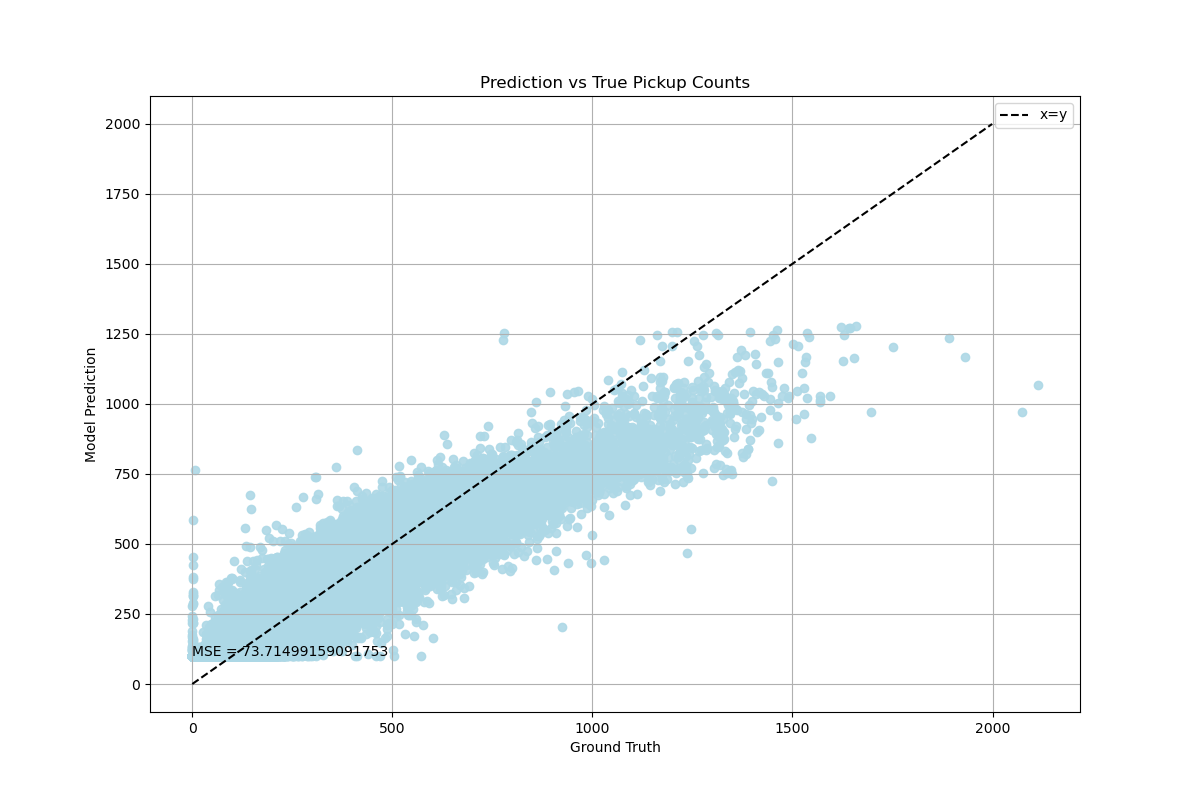

In [28]:
prev_hrs = 4
prev_days = 2
prev_weeks = 2
forecast_horizon = 1
include_weather = False
batch_size =32
device ='cuda:3'
dtype= torch.float64
nyc_test = NYCTripDataset('test', test_data,
                            prev_hrs=prev_hrs,
                            prev_days=prev_days, 
                            prev_weeks=prev_weeks, 
                            forecast_horizon=forecast_horizon, 
                            include_weather=include_weather,
                            device=device, dtype=dtype)

test_dataloader = DataLoader(nyc_test, batch_size=batch_size, shuffle=False)
criterion = torch.nn.MSELoss(reduction='mean')

mean = torch.tensor(scalers[29].mean_).to(device, dtype=torch.float64)
std = torch.tensor(scalers[29].scale_).to(device, dtype=torch.float64)

def test_visualize(model, test_dataloader, **kwargs):
    fig, axe = plt.subplots(1,1, figsize=(12,8))#kwargs.get('figsize',(10,10))
    model.eval()
    batch_loss = 0
    batch_maerl = 0
    num_batches = 0
    for data in test_dataloader:
        out = model(data.x, data.edge_index)
        y_pred = out * std + mean
        y_true = data.y * std + mean
        loss, mean_abs_rel_err = loss_fn(out, data.y, mean, std)
        if not math.isnan(loss.item()):
            batch_loss += loss.item()
            batch_maerl += mean_abs_rel_err.item()
            num_batches += 1
            axe.scatter(y_true.detach().cpu().flatten().numpy(),y_pred.detach().cpu().flatten().numpy(),
                        color='lightblue', alpha=0.9)
    mse = batch_loss/(batch_size*num_batches)
    return fig, axe, mse




Text(0, 2000, 'MSE = 73.71499159091753')

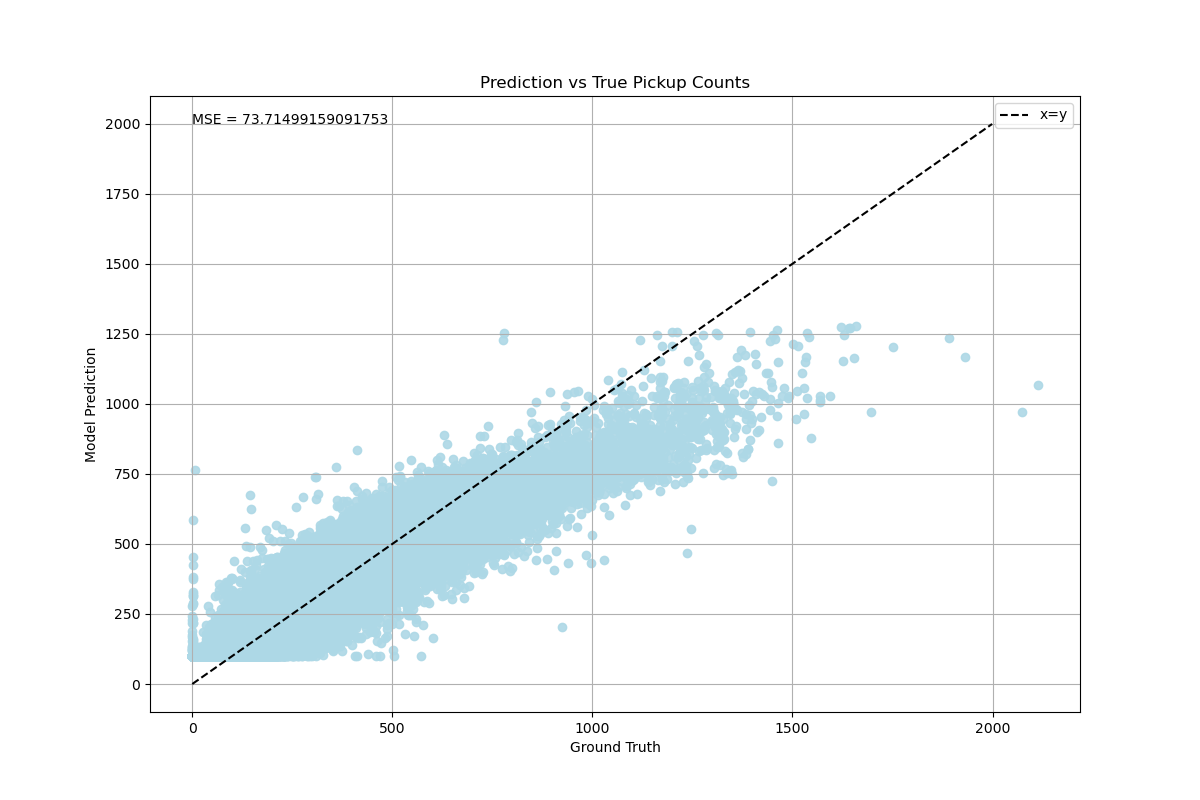

In [29]:
# fig, axe, mse = test_visualize(model, test_dataloader)
x = np.arange(0,2000)
axe.plot(x,x, linestyle='--', color='k', label='x=y');
axe.set_xlabel("Ground Truth")
axe.set_ylabel("Model Prediction")
axe.grid(True)
axe.legend()fig, axe, mse = test_visualize(model, test_dataloader)
x = np.arange(0,2000)
axe.plot(x,x, linestyle='--', color='k', label='x=y');
axe.set_xlabel("Ground Truth")
axe.set_ylabel("Model Prediction")
axe.grid(True)
axe.legend()
axe.set_title('Prediction vs True Pickup Counts')
axe.text(0,100, f'MSE = {mse}')
axe.set_title('Prediction vs True Pickup Counts')
axe.text(0,2000, f'MSE = {mse}')